# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Данные геологоразведки трёх регионов находятся в файлах: geo_data_0.csv, geo_data_1.csv и geo_data_2.csv.
- id — уникальный идентификатор месторождения;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в месторождении (тыс. баррелей).

Условия:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона проводится исследование 500 точек.
- Бюджет на разработку месторождений — 10 млрд рублей, стоимость бурения одной скважины — 50 млн рублей.
- Один баррель сырья приносит 4500 рублей прибыли.
- Не рассматривать регионы, в которых риск убытков выше 2.5%. Из оставшихся выбирается регион с наибольшей средней прибылью.

# 1. Загрузка и подготовка данных

Краткий план:
- Смотрим распределение продуктов по каждому региону
- Готовим выборку для обучения
- Обучаем модель
- Считаем средние количество запасов. Смотрим среднеквадратическую ошибку и абсолютную среднюю ошибку. Вывод
- Подготавливаем функцию для расчета прибыли и рисков убытков
- Bootstrap-ом 1000 раз выдергиваем по 500 элементов случайным образом с возвращением из выборок предсказаний и целевой для каждого региона
- Смотрим среднее значение прибыли и рисков по каждому региону
- Сводная таблица

In [2]:
import pandas as pd
import matplotlib as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from numpy.random import RandomState
from scipy import stats as st


In [3]:
geo_data_0=pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1=pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2=pd.read_csv('/datasets/geo_data_2.csv')


In [284]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [285]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [286]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [287]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Все данные в порядке. Пропусков нет! Типы данных тоже в порядке!

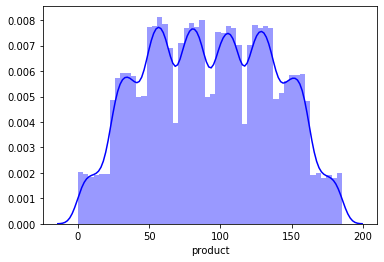

In [288]:
#geo_data_0['product'].hist(bins=30,figsize=(10,6),title='')

sns.distplot(geo_data_0['product'],  color= "b") 

Распределение сырья в месторождении geo_data_0

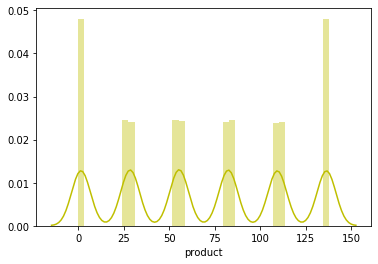

In [289]:
sns.distplot(geo_data_1['product'],  color= "y") 

Распределение сырья в месторождении geo_data_1

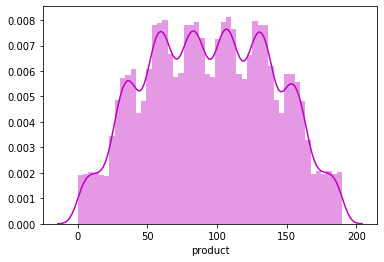

In [290]:
sns.distplot(geo_data_2['product'],  color= "m") 

Распределение сырья в месторождении geo_data_2

По распределению сырья видно, что распределение не нормальное. Bootstrap потом сделаем его нормальным 

In [291]:
# готовим выборки для обучения. Разбиваем на целевой признак и признаки
features_1=geo_data_0.drop(['product','id'],axis=1)
target_1=geo_data_0['product']

features_2=geo_data_1.drop(['product','id'],axis=1)
target_2=geo_data_1['product']

features_3=geo_data_2.drop(['product','id'],axis=1)
target_3=geo_data_2['product']

In [292]:
# готовим обучающую, валидную и тестовую выборку
train_features_1,valid_features_1,train_target_1,valid_target_1=train_test_split(features_1,target_1,test_size=.25,random_state=1234)
train_features_2,valid_faetures_2,train_target_2,valid_target_2=train_test_split(features_2,target_2,test_size=.25,random_state=1234)
train_features_3,valid_features_3,train_target_3,valid_target_3=train_test_split(features_3,target_3,test_size=.25,random_state=1234)

# 2. Обучение и проверка модели

In [293]:
# Обучаем моделью линейной регрессии
model_reg_1=LinearRegression().fit(train_features_1,train_target_1)

In [294]:
#Предсказания модели
prediction_1=model_reg_1.predict(valid_features_1)

In [295]:
print('Средний запас сырья:',prediction_1.mean(),'RMSE:',np.sqrt(mean_squared_error(prediction_1,valid_target_1)),'MAE:',mean_absolute_error(prediction_1,valid_target_1))

Средний запас сырья: 92.43045952558441 RMSE: 37.56239418363779 MAE: 30.938765880476645


In [296]:
model_reg_2=LinearRegression().fit(train_features_2,train_target_2)

In [297]:
prediction_2=model_reg_2.predict(valid_faetures_2)

In [298]:
print('Средний запас сырья:',prediction_2.mean(),'RMSE:',np.sqrt(mean_squared_error(prediction_2,valid_target_2)),'MAE:',mean_absolute_error(prediction_2,valid_target_2))

Средний запас сырья: 68.80248249798366 RMSE: 0.8939344738117693 MAE: 0.7208749581371279


In [299]:
model_reg_3=LinearRegression().fit(train_features_3,train_target_3)

In [300]:
prediction_3=model_reg_3.predict(valid_features_3)

In [301]:
print('Средний запас сырья:',prediction_3.mean(),'RMSE:',np.sqrt(mean_squared_error(prediction_3,valid_target_3)),'MAE:',mean_absolute_error(prediction_3,valid_target_3))

Средний запас сырья: 94.91573817913459 RMSE: 40.10318099258418 MAE: 32.86813268581066


In [302]:
mse_data={'geo_data_0':np.array([92.43,37.562,30.93]),'geo_data_1':np.array([68.80,0.893,0.72]),'geo_data_2':np.array([94.92,40.10,32.868])}
data=pd.DataFrame(mse_data,index=['Средний запас сырья, тыс.бареллей','RMSE','MAE'])

In [303]:
data

,geo_data_0,geo_data_1,geo_data_2
"Средний запас сырья, тыс.бареллей",92.430,68.800,94.920
RMSE,37.562,0.893,40.100
MAE,30.930,0.720,32.868


# 3. Подготовка к расчёту прибыли

In [304]:
N=500 # При разведке региона проводится исследование 500 точек.
BUDGET_FOR_1=10**9 # Бюджет на разработку месторождений — 10 млрд рублей
COAST_ONE_WELL=50*10**6 # стоимость бурения одной скважины — 50 млн рублей.
BURREL=4500 # Один баррель сырья приносит 4500 рублей прибыли.

### Минимальный объем сырья

In [305]:
min_product=COAST_ONE_WELL/BURREL
print('Минимальный объём сырья в месторождениях региона, достаточный для его разработки',min_product/1000,'тыс.бареллей')

Минимальный объём сырья в месторождениях региона, достаточный для его разработки 11.11111111111111 тыс.бареллей


In [306]:
data

,geo_data_0,geo_data_1,geo_data_2
"Средний запас сырья, тыс.бареллей",92.430,68.800,94.920
RMSE,37.562,0.893,40.100
MAE,30.930,0.720,32.868


#### Вывод:
Сравнивая значения среднего запаса сырья в трех месторождениях и минимального объема запасов достаточного для его разработки, можно сделать вывод для каждого месторождения среднего объема сырья достаточно для разработки.
Оценивая среднеквадратичную ошибку предсказания и целевого признака  можно сделать, лучше всего предсказано месторождение geo_data_1. Остальные месторождения предсказаны с большой ошибкой.
Также можно заметить, что у месторождения (geo_data_1), которое предсказано лучше всех, меньше всего среднего запаса сырья, чем у остальных. Можно сделать вывод, что из-за большой ошибки значения среднего запаса могут быть другими.
Попробуем применить технологию Bootstrap, чтобы получить нормальное распределение данных и использовать статистический функционал.

### Расчёта прибыли по набору отобранных месторождений и предсказаний модели.

In [307]:
# Функция расчета прибыли
def pribil(data):
    pribil=[]
    pribil.append((data*1000*BURREL)/1000000) # умножаем запас сырья на цена за барелль 
    return np.mean(pribil)  # возвращаем сумму прибыли

# 4. Расчёт прибыли и рисков 

In [308]:
# Функция расчета рисков
def demage(data):
    demage_data=[]
    demage_data.append((data[data<0]*1000*BURREL)/1000000)
   
    return np.sum(demage_data)

In [309]:
prediction_1=pd.Series(prediction_1)
valid_target_1=pd.Series(valid_target_1)

prediction_2=pd.Series(prediction_2)
valid_target_2=pd.Series(valid_target_2)

prediction_3=pd.Series(prediction_3)
valid_target_3=pd.Series(valid_target_3)

In [310]:
state = np.random.RandomState(12345)

In [311]:
#Bootstrap
values_1=[]
values_2=[]
values_3=[]
dem_1=[]
dem_2=[]
dem_3=[]

for i in range(1000):
    
    # Делаю выборку по 500 точек 1-ого региона
    target_subsample_1=valid_target_1.sample(n=N,random_state=state,replace=True)
    predict_subsample_1=prediction_1.sample(n=N,random_state=state,replace=True)
    sum_target_predict_1=pd.concat([target_subsample_1,predict_subsample_1])
    
    # Делаю выборку по 500 точек 2-ого региона
    target_subsample_2=valid_target_2.sample(n=N,random_state=state,replace=True)
    predict_subsample_2=prediction_2.sample(n=N,random_state=state,replace=True)
    sum_target_predict_2=pd.concat([target_subsample_2,predict_subsample_2])
    
    
    # Делаю выборку по 500 точек 3-ого региона
    target_subsample_3=valid_target_3.sample(n=N,random_state=state,replace=True)
    predict_subsample_3=prediction_3.sample(n=N,random_state=state,replace=True)
    sum_target_predict_3=pd.concat([target_subsample_3,predict_subsample_3])
   
    # подсчет прибыли и рисков вызовом функций
    values_1.append(np.mean(pribil(sum_target_predict_1)))
    dem_1.append(np.mean(demage(sum_target_predict_1)))
    
    values_2.append(np.mean(pribil(sum_target_predict_2))) 
    dem_2.append(np.mean(demage(sum_target_predict_2)))
    
    values_3.append(np.mean(pribil(sum_target_predict_3))) 
    dem_3.append(np.mean(demage(sum_target_predict_3)))
    

In [312]:
# Перевожу в Series
values_1=pd.Series(values_1)
values_2=pd.Series(values_2)
values_3=pd.Series(values_3)

dem_1=pd.Series(dem_1)
dem_2=pd.Series(dem_2)
dem_3=pd.Series(dem_3)

### Регион 1

In [313]:
print('средняя прибыль месторождения 1:',values_1.mean(),'млн. рублей')

средняя прибыль месторождения 1: 416.20273637249375 млн. рублей


In [256]:
confidence_interval_1 =st.t.interval(0.95,df=len(values_1)-1,loc=values_1.mean(),scale =values_1.sem()) 

print("95%-ый доверительный интервал:", confidence_interval_1)

95%-ый доверительный интервал: (415.6521834624191, 416.3040449727737)


In [237]:
lower =values_1.quantile(0.025)
upper = values_1.quantile(0.975)

In [238]:
lower # 2.5% квантиль

405.67945529137484

In [239]:
upper # 97.5 квантиль

425.46835084993813

Риск убытков: 

In [262]:
demage_1=np.abs(dem_1.mean()/N)*100
print('Риск убытков:',demage_1,'%')

Риск убытков: 0.0 %


### Регион 2

In [263]:
print('средняя прибыль месторождения 2:',values_2.mean(),'млн. рублей')

средняя прибыль месторождения 2: 309.6016231545892 млн. рублей


In [276]:
confidence_interval_2 =st.t.interval(0.95,df=len(values_2)-1,loc=values_2.mean(),scale =values_2.sem()) 

print("95%-ый доверительный интервал:", confidence_interval)

95%-ый доверительный интервал: (427.1641895778832, 427.7569187932905)


In [265]:
lower =values_2.quantile(0.025)
upper = values_2.quantile(0.975)

In [266]:
lower # 2.5% квантиль

296.5659394211574

In [267]:
upper # 97.5 квантиль

322.08677651662686

Риск убытков: 

In [268]:
demage_2=np.abs(dem_2.mean()/N)*100
print('Риск убытков:',demage_2,'%')

Риск убытков: 4.4083259625753985 %


### Регион 3

In [269]:
print('средняя прибыль месторождения 2:',values_3.mean(),'млн. рублей')

средняя прибыль месторождения 2: 427.46055418558683 млн. рублей


In [277]:
confidence_interval_3 =st.t.interval(0.95,df=len(values_3)-1,loc=values_3.mean(),scale =values_3.sem()) 

print("95%-ый доверительный интервал:", confidence_interval)

95%-ый доверительный интервал: (427.1641895778832, 427.7569187932905)


In [271]:
lower =values_3.quantile(0.025)
upper = values_3.quantile(0.975)

In [272]:
lower # 2.5% квантиль

417.6574804905129

In [273]:
upper # 97.5 квантиль

436.6604528585062

Риск убытков: 

In [258]:
demage_3=np.abs(dem_3.mean()/N)*100
print('Риск убытков:',demage_3,'%')

Риск убытков: 0.0 %


## Вывод:

Сводная таблица

In [316]:
geo={'geo_data_0':np.array([values_1.mean(),confidence_interval_1,demage_1,]),'geo_data_1':np.array([values_2.mean(),confidence_interval_2,demage_2]),'geo_data_2':np.array([values_3.mean(),confidence_interval_3,demage_3])}
new_data=pd.DataFrame(geo,index=['Средняя прибыль, млн.руб','Доверительный интервал 95%','Риск убытков, %'])

In [317]:
new_data

,geo_data_0,geo_data_1,geo_data_2
"Средняя прибыль, млн.руб",416.203,309.709,426.955
Доверительный интервал 95%,"(415.6521834624191, 416.3040449727737)","(309.1945288018896, 310.00871750728885)","(427.1641895778832, 427.7569187932905)"
"Риск убытков, %",0,4.40833,0


Оценивая средние значения прибыли после Bootstrap можно сделать выводы, что самым прибыльным районом оказался geo_data_2. Средняя прибыль по нему составляет 426.955 млн. рублей. На втором месте регион geo_data_0 со средней прибылью 416.203 млн. руб. Самым неблагоприятным районом для осваивания является  geo_data_1. Средняя прибыл по нему 309.709 млн. руб. И по нему риски убытка 4,4% (не рассматриваем по условию). У Всех остальных рисков убытка нет!